# Plasma physics
By Alan Kaptanoglu, with some edits by Brian de Silva

This example is based off of the preprint found [here](https://arxiv.org/pdf/2004.10389.pdf)
and builds a data-driven dynamical system model for the temporal POD modes from an isothermal Hall-magnetohydrodynamic (Hall-MHD) plasma simulation of the HIT-SI experiment at the University of Washington.

This notebook shows off some advanced PySINDy features that were useful for this work:
1. Initial guesses to the SINDy optimization object
2. SR3 algorithm with linear equality constraints 
    (see [this preprint](https://arxiv.org/abs/1906.10612))
3. Matrix of thresholds, implemented only for ` ConstrainedSR3` for now 
    (although `ConstrainedSR3` can be used without using constraints and is then equivalent to `SR3`).

## Setup

In [1]:
import warnings

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy.integrate import odeint

import pysindy as ps

In [2]:
def pareto_curve(
    optimizer,
    feature_library,
    differentiation_method,
    feature_names,
    discrete_time,
    thresholds,
    x_fit,
    x_test,
    t_fit,
    t_test,
):
    """
    Function which sweeps out a Pareto Curve in (r, lambda)

    Parameters
    ----------

    optimizer : optimizer object, optional
        Optimization method used to fit the SINDy model. This must be a class
        extending :class:`pysindy.optimizers.BaseOptimizer`.
        The default is :class:`STLSQ`.

    feature_library : feature library object, optional
        Feature library object used to specify candidate right-hand side features.
        This must be a class extending
        :class:`pysindy.feature_library.base.BaseFeatureLibrary`.
        The default option is :class:`PolynomialLibrary`.

    differentiation_method : differentiation object, optional
        Method for differentiating the data. This must be an object that
        extends :class:`pysindy.differentiation_methods.BaseDifferentiation`.
        Default is centered difference.

    feature_names : list of string, length n_input_features, optional
                                                                                                                  
    discrete_time : boolean, optional (default False)
        If True, dynamical system is treated as a map. Rather than predicting
        derivatives, the right hand side functions step the system forward by
        one time step. If False, dynamical system is assumed to be a flow
        (right hand side functions predict continuous time derivatives).

    thresholds: array of floats
        The list of thresholds to change the number of terms available to the
        SINDy model, generating a Pareto curve.

    x_fit: array-like or list of array-like, shape
        (n_samples, n_input_features)
        Training data.

    x_test: array-like or list of array-like, shape
        (n_samples, n_input_features)
        Testing data.

    t_fit: array of floats
        Time slices corresponding to the training data.

    t_test: array of floats
    """
    model_scores = []
    non_zeros_coeffs = []
    x_err = []
    xdot_err = []

    # Loop over the threshold values of interest
    for j in range(len(thresholds)):
        optimizer._set_threshold(thresholds[j])
        model = ps.SINDy(
            optimizer=optimizer,
            feature_library=feature_library,
            differentiation_method=differentiation_method(drop_endpoints=True),
            feature_names=feature_names,
            discrete_time=discrete_time,
        )

        # Compute predicted X and Xdot
        model.fit(x_fit, t=t_fit, quiet=True)
        x0 = x_test[0, :]
        x_sim = model.simulate(
            x0,
            t_test,
            integrator=odeint,
            stop_condition=None,
        )
        xdot_test = model.differentiate(x_test, t=t_test)[1:-2]
        xdot_sim = model.predict(x_test)[1:-2]

        # Compute frobenius error of X and Xdot on the "testing" data
        x_err.append(np.linalg.norm(x_test - x_sim))
        xdot_err.append(np.linalg.norm(xdot_test - xdot_sim))
        num_coeff = len(np.ravel(model.coefficients()))
        num_nonzero_coeff = np.count_nonzero(model.coefficients())
        non_zeros_coeffs.append(num_nonzero_coeff / num_coeff * 100)
        model_scores.append(min((1 - min(model.score(x_test, t=t_test), 1)) * 100, 100))

    # Save the errors and other metrics of model performance to file
    errs = np.zeros((len(model_scores), 5))
    errs[:, 0] = non_zeros_coeffs
    errs[:, 1] = thresholds
    errs[:, 2] = model_scores
    errs[:, 3] = x_err
    errs[:, 4] = xdot_err
    return errs

In [3]:
cmap = plt.get_cmap("Set1")

def plot_trajectories(x, x_train, x_sim, n_modes=None):
    """
    Compare x (the true data), x_train (predictions on the training data),
    and x_sim (predictions on the test data).
    """
    if n_modes is None:
        n_modes = x_sim.shape[1]

    n_rows = (n_modes + 1) // 2
    kws = dict(alpha=0.7)

    fig, axs = plt.subplots(n_rows, 2, figsize=(12, 2 * n_rows), sharex=True)
    for i, ax in zip(range(n_modes), axs.flatten()):
        ax.plot(t, x[:, i], color="Gray", label="True", **kws)
        ax.plot(t_train, x_train[:, i], color=cmap(1), label="Predicted (train)", **kws)
        ax.plot(t_test, x_sim[:, i], color=cmap(0), label="Predicted (test)", **kws)
        ax.set(title="POD mode {}".format(i + 1))
        ax.legend(bbox_to_anchor=(0, -0.05), ncol=3, loc="upper left")

    for ax in axs.flatten():
        ax.grid(True)
        ax.set(xticklabels=[], yticklabels=[])

    fig.tight_layout()

In [4]:
def plot_coefficients(coefficients, input_features=None, feature_names=None, ax=None, **heatmap_kws):
    """Plot learned coefficient matrix in human-readable way."""
    if input_features is None:
        input_features = [f"$\dot x_{k}$" for k in range(coefficients.shape[0])]
    else:
        input_features = [f"$\dot {fi}$" for fi in input_features]
    
    if feature_names is None:
        feature_names = [f"f{k}" for k in range(coefficients.shape[1])]

        
    with sns.axes_style(style="white", rc={"axes.facecolor": (0, 0, 0, 0)}): 
        if ax is None:
            fig, ax = plt.subplots(1, 1)
        
        max_mag = np.max(np.abs(coefficients))
        heatmap_args = {
            "xticklabels": input_features,
            "yticklabels": feature_names,
            "center": 0.0,
            "cmap": sns.color_palette("vlag", n_colors=20),
            "ax": ax,
            "linewidths": 0.1,
            "linecolor": "whitesmoke",
        }
        heatmap_args.update(**heatmap_kws)

        sns.heatmap(
            coefficients.T,
            **heatmap_args
        )

        ax.tick_params(axis="y", rotation=0)
    
    return ax

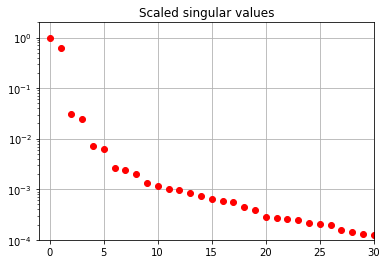

In [5]:
# Load in temporal POD modes of a plasma simulation (trajectories in time)
A = np.loadtxt("data/plasmaphysics_example_trajectories.txt")
t = A[:, 0]
A = A[:,1:]

# Load in the corresponding SVD data and plot it
S = np.loadtxt("data/plasmaphysics_example_singularValues.txt")
fig, ax = plt.subplots(1, 1)
ax.semilogy(S / S[0], "ro")
ax.set(title="Scaled singular values", xlim=[-1, 30], ylim=[1e-4, 2])
ax.grid()

## Learning SINDy models for POD mode dynamics


### Unconstrained SR3 algorithm
Let's run a quadratic SINDy model on the first 7 POD modes using the unconstrainted SR3 algorithm with an initial guess.

In [6]:
r = 7
poly_order = 2
threshold = 0.05
tfrac = 0.8  # Proportion of the data to train on

M = len(t)
M_train = int(len(t) * tfrac)
t_train = t[:M_train]
t_test = t[M_train:]

pod_names = ["a{}".format(i) for i in range(1, r + 1)]

# Normalize the trajectories to the unit ball for simplicity
normalization = sum(np.amax(abs(A), axis=0)[1 : r + 1])
x = np.zeros((A.shape[0],r))
for i in range(r):
    x[:, i] = A[:, i] / normalization
    
# Build an initial guess
initial_guess = np.zeros((r,r + int(r * (r + 1) / 2)))
initial_guess[0, 1] = 0.091
initial_guess[1, 0] = -0.091
initial_guess[2, 3] = 0.182
initial_guess[3, 2] = -0.182
initial_guess[5, 4] = -3 * 0.091
initial_guess[4, 5] = 3 * 0.091

x_train = x[:M_train, :]
x0_train = x[0, :]
x_test = x[M_train:, :]
x0_test = x[M_train, :]

In [7]:
# To exclude the constant function from the library we could normally do:
# sindy_library = ps.PolynomialLibrary(degree=poly_order, include_bias=False)
# but here we need to move around the terms a bit to make the quadratic constraint work out
library_functions = [lambda x:x, lambda x, y:x*y, lambda x:x**2]
library_function_names = [lambda x:x, lambda x, y:x+y, lambda x:x+x]
sindy_library = ps.CustomLibrary(library_functions=library_functions,
                                    function_names=library_function_names)
    
# SR3 optimizer with an initial guess
sindy_opt = ps.SR3(
    threshold=threshold, nu=1, initial_guess=initial_guess, max_iter=1000
)

model = ps.SINDy(
    optimizer=sindy_opt,
    feature_library=sindy_library,
    differentiation_method=ps.FiniteDifference(drop_endpoints=True),
    feature_names=pod_names,
)

# Fit a model on the training data
model.fit(x_train, t=t_train)
model.print()

a1' = 0.090 a2
a2' = -0.091 a1
a3' = 0.179 a4
a4' = -0.179 a3
a5' = 0.263 a6
a6' = -0.263 a5
a7' = 0.000


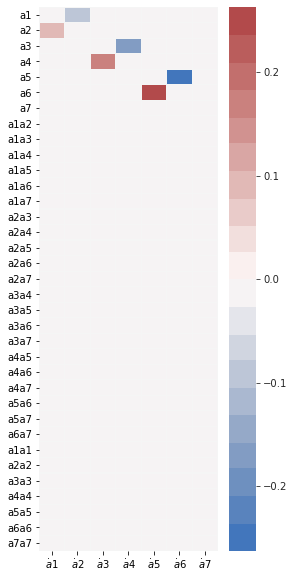

In [8]:
feature_names = model.get_feature_names()

fig, ax = plt.subplots(1, 1, figsize=(4, 10))
plot_coefficients(model.coefficients(), input_features=pod_names, feature_names=feature_names, ax=ax);

In [9]:
# Get Xdot from the measurement data X
x_dot = model.differentiate(x, t=t)

# Predict Xdot on the training and testing data. Since the model was trained on
# Xdot from the training data, x_dot_train is often in excellent agreement with x_dot.
x_dot_train = model.predict(x_train)
x_dot_sim = model.predict(x_test)

print("Model score:", model.score(x, t=t))

Model score: 0.8315081674949204


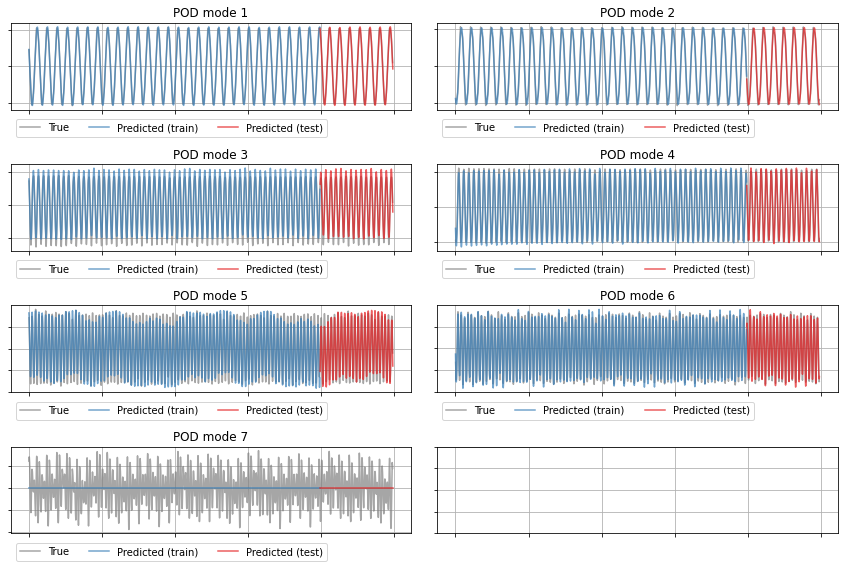

In [10]:
# Plot predicted derivatives
plot_trajectories(x_dot, x_dot_train, x_dot_sim, n_modes=r)

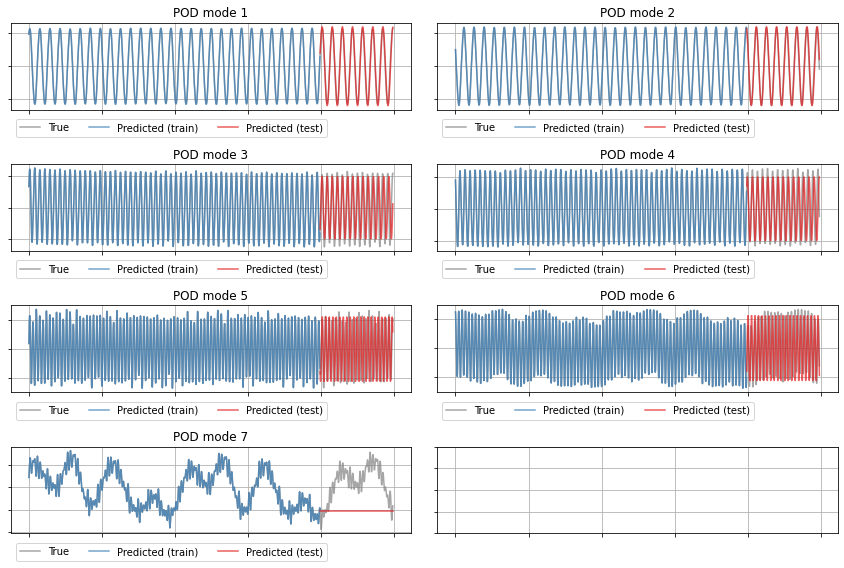

In [11]:
# Forecast the testing data with this identified model
x_sim = model.simulate(x0_test, t_test)

# Compare true and simulated trajectories
plot_trajectories(x, x_train, x_sim, n_modes=r)

### Constrained SR3 algorithm
Now let's run a SINDy model on the first 7 modes using the constrainted SR3 algorithm with an initial guess. The constraint is that the linear part of the SINDy coefficient matrix must be anti-symmetric. Note in the resulting model, we have $\dot a_1 = 0.091a_2,\ \dot a_2 = -0.091a_1$, and so on.

This constraint is specific to the magnetohydrodynamics (MHD) model used for the provided simulation data.

In [12]:
threshold = 0.05
constraint_zeros = np.zeros(int(r * (r + 1) / 2))
constraint_matrix = np.zeros((int(r * (r + 1) / 2), int(r * (r ** 2 + 3 * r) / 2)))

# Define the constraint matrix
q = r
for i in range(r):
    constraint_matrix[i, i * (r + 1)] = 1.0
    counter = 1
    for j in range(i + 1, r):
        constraint_matrix[q, i * r + j] = 1.0
        constraint_matrix[q, i * r + j + counter * (r - 1)] = 1.0
        counter += 1
        q += 1

sindy_opt = ps.ConstrainedSR3(
    threshold=threshold,
    nu=1,
    max_iter=10000,
    constraint_lhs=constraint_matrix,
    constraint_rhs=constraint_zeros,
    constraint_order="feature",
    tol=1e-6,
    initial_guess=initial_guess,
)

In [13]:
model = ps.SINDy(
    optimizer=sindy_opt,
    feature_library=sindy_library,
    differentiation_method=ps.FiniteDifference(drop_endpoints=True),
    feature_names=pod_names,
)

model.fit(x_train, t=t_train)
model.print()

a1' = 0.091 a2
a2' = -0.091 a1
a3' = 0.179 a4
a4' = -0.179 a3
a5' = 0.263 a6
a6' = -0.263 a5
a7' = 0.000


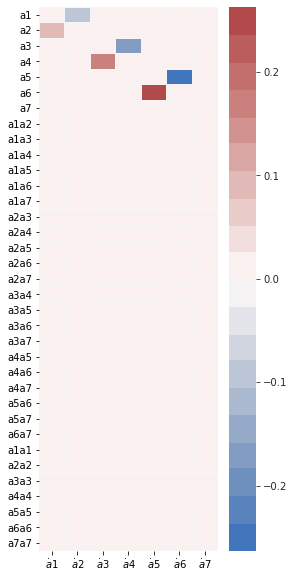

In [14]:
fig, ax = plt.subplots(1, 1, figsize=(4, 10))
plot_coefficients(model.coefficients(), input_features=pod_names, feature_names=feature_names, ax=ax);

In [15]:
print("Model score:", model.score(x, t=t))

Model score: 0.8315075123206278


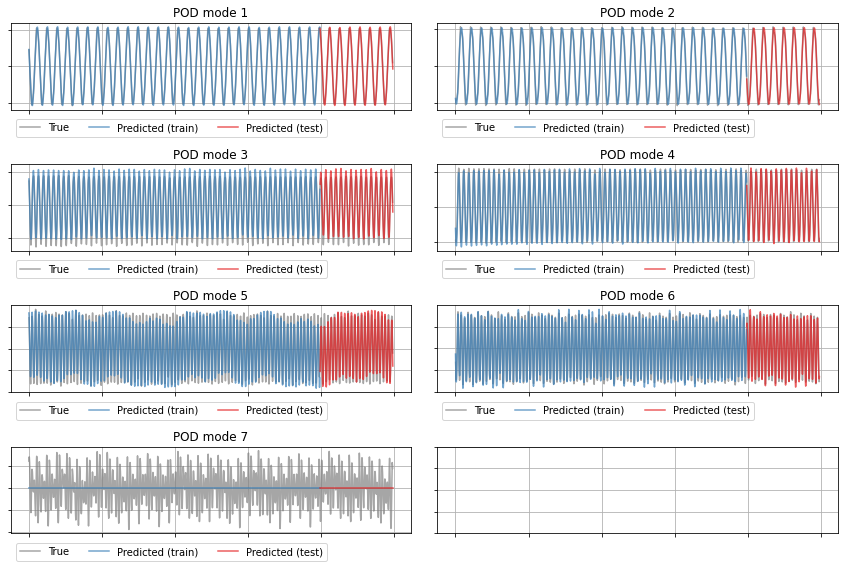

In [16]:
x_dot = model.differentiate(x, t=t)
x_dot_train = model.predict(x_train)
x_dot_sim = model.predict(x_test)

plot_trajectories(x_dot, x_dot_train, x_dot_sim, n_modes=r)

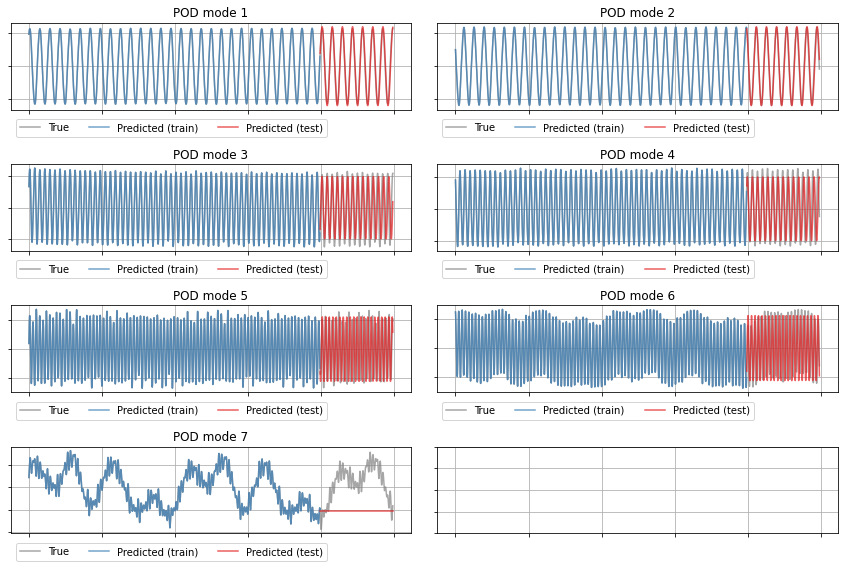

In [17]:
x_sim = model.simulate(x0_test, t_test)
plot_trajectories(x, x_train, x_sim, r)

### Constrained SR3 algorithm with term-dependent thresholding

Finally, we train a SINDy model on the first 7 modes using constrained SR3 with an initial guess *and* different thresholds for different library terms. We'll test out two sets of thresholds.

#### Encourage linear terms
We'll try get the model to emphasize linear terms by increasing thresholding on the quadratic terms.

In [18]:
threshold = 0.05

# Define a matrix of thresholds
thresholder = "weighted_l0"
thresholds = threshold * np.ones((r, r + int(r * (r + 1) / 2)))

# Make the thresholds for the quadratic terms very large
thresholds[:, r:] = 30 * threshold

sindy_opt = ps.ConstrainedSR3(
    threshold=threshold,
    nu=10,
    max_iter=50000,
    constraint_lhs=constraint_matrix,
    constraint_rhs=constraint_zeros,
    constraint_order="feature",
    tol=1e-5,
    thresholder=thresholder,
    initial_guess=initial_guess,
    thresholds=thresholds,
)

In [19]:
model = ps.SINDy(
    optimizer=sindy_opt,
    feature_library=sindy_library,
    differentiation_method=ps.FiniteDifference(drop_endpoints=True),
    feature_names=pod_names,
)
model.fit(x_train, t=t_train)
model.print()

a1' = 0.091 a2
a2' = -0.091 a1
a3' = 0.179 a4
a4' = -0.179 a3
a5' = 0.262 a6 + -0.052 a7
a6' = -0.262 a5
a7' = 0.052 a5


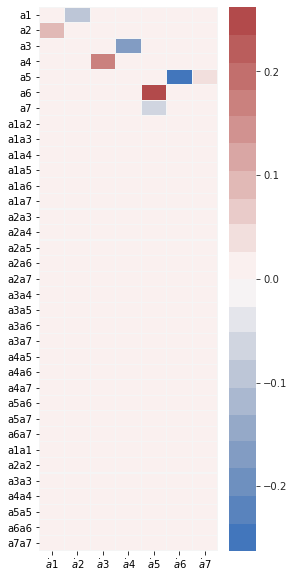

In [20]:
fig, ax = plt.subplots(1, 1, figsize=(4, 10))
plot_coefficients(model.coefficients(), input_features=pod_names, feature_names=feature_names, ax=ax);

In [21]:
x_dot = model.differentiate(x, t=t)
x_dot_train = model.predict(x_train)
x_dot_sim = model.predict(x_test)
print("Model score:", model.score(x, t=t))

Model score: 0.875402457830791


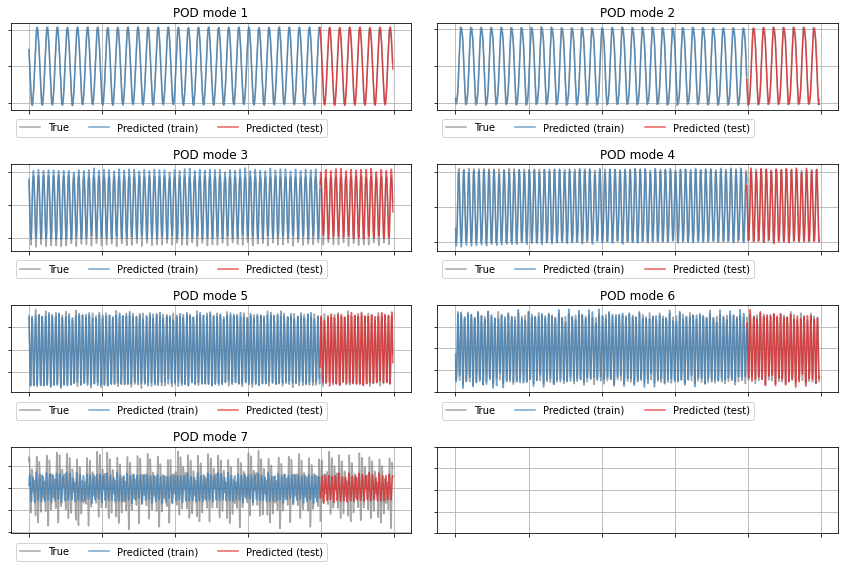

In [22]:
plot_trajectories(x_dot, x_dot_train, x_dot_sim, n_modes=r)

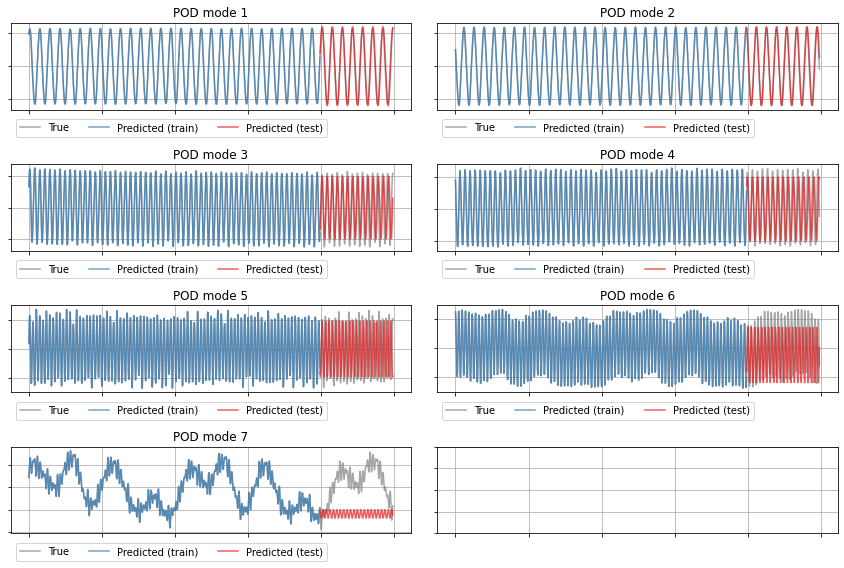

In [23]:
x_sim = model.simulate(x0_test, t_test)
plot_trajectories(x, x_train, x_sim, n_modes=r)

#### Allow some quadratic terms

The linear terms look pretty good but there are still some small errors in the frequencies
and they can't seem to capture the 7th mode. Let's demand quadratic models for a3-a7. Although 
we can mess around with these thresholds for better performance, there is a limit
to the progress we can make with this set of modes -- modes 1-6 are close to monochromatic
which will make it difficult to capture frequency dependence beyond the driving frequency
and its harmonics.

In [24]:
threshold = 0.05
thresholder = "weighted_l0"
thresholds = threshold * np.ones((r, r + int(r * (r + 1) / 2)))

# Try complicated set of thresholding (try playing around with these)
thresholds[0:2, r:] = 30 * threshold
thresholds[2, r:] = 0.2
thresholds[3, r:] = 0.05
thresholds[4:6, r:] = 0.03

In [25]:
sindy_opt = ps.ConstrainedSR3(
    threshold=threshold,
    nu=10,
    max_iter=50000,
    constraint_lhs=constraint_matrix,
    constraint_rhs=constraint_zeros,
    constraint_order="feature",
    tol=1e-5,
    thresholder=thresholder,
    initial_guess=initial_guess,
    thresholds=thresholds,
)

model = ps.SINDy(
    optimizer=sindy_opt,
    feature_library=sindy_library,
    differentiation_method=ps.FiniteDifference(drop_endpoints=True),
    feature_names=pod_names,
)

model.fit(x_train, t=t_train)
model.print()

a1' = 0.091 a2
a2' = -0.091 a1
a3' = 0.180 a4
a4' = -0.180 a3 + -0.203 a1a6 + -0.204 a2a5 + -0.095 a3a4
a5' = 0.263 a6 + -0.053 a7 + -0.116 a2a5 + 0.115 a3a5 + 0.172 a3a7 + -0.082 a4a6
a6' = -0.263 a5 + -0.089 a4a6 + -0.249 a4a7
a7' = 0.053 a5 + 0.205 a1a5 + 0.263 a1a6 + 0.213 a2a5 + -0.133 a2a6 + 0.488 a3a4 + 0.145 a4a6 + 0.317 a3a3 + -0.352 a4a4


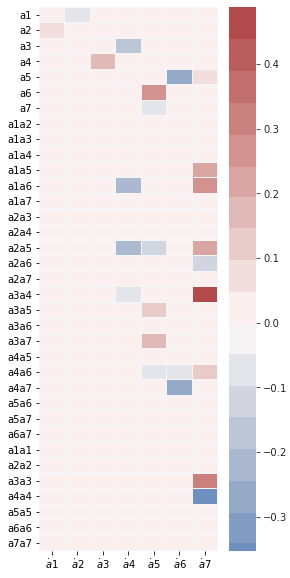

In [26]:
fig, ax = plt.subplots(1, 1, figsize=(4, 10))
plot_coefficients(model.coefficients(), input_features=pod_names, feature_names=feature_names, ax=ax);

In [27]:
print("Model score:", model.score(x, t=t))

Model score: 0.975345517544386


In [28]:
x_dot = model.differentiate(x, t=t)
x_dot_train = model.predict(x_train)
x_dot_sim = model.predict(x_test)

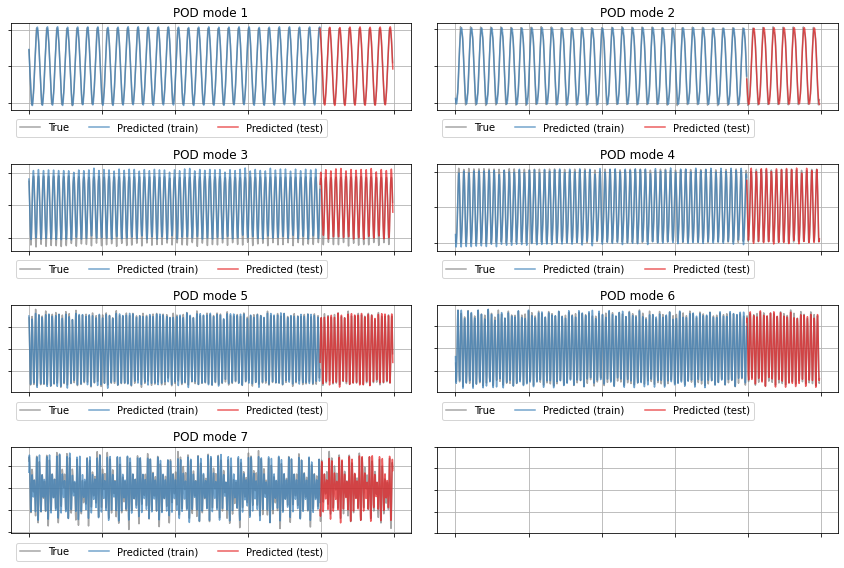

In [29]:
plot_trajectories(x_dot, x_dot_train, x_dot_sim, n_modes=r)

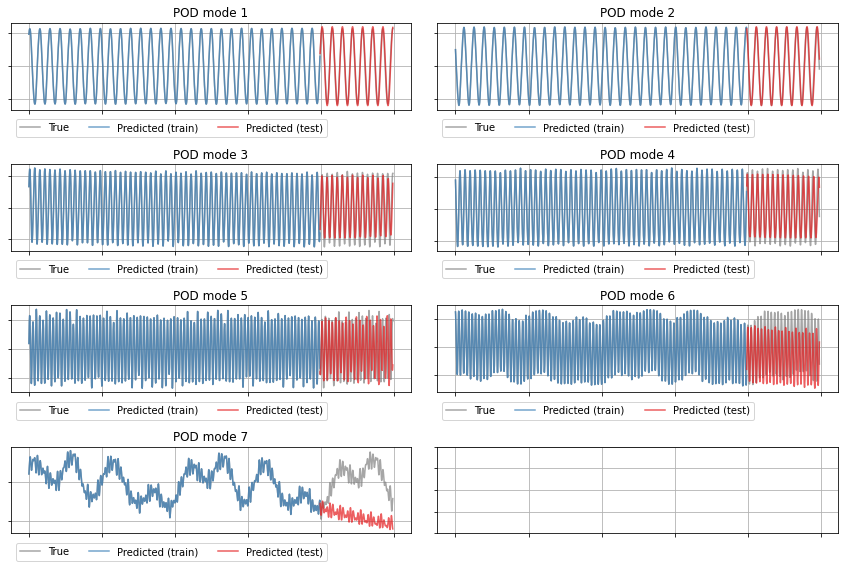

In [30]:
x_sim = model.simulate(x0_test, t_test)
plot_trajectories(x, x_train, x_sim, n_modes=r)

#### Show off quadratic constraints

Although this constraint is not suitable for these simulations, we use it here below to demonstrate linear + quadratic constraints for arbitrary r, which can be useful for some fluid and plasma systems. Note that the variable thresholding will mess up the quadratic constraints.

In [31]:
if poly_order == 2:
    constraint_zeros = np.zeros((int(r*(r+1)/2) + r + r*(r-1) + int(r*(r-1)*(r-2)/6.0)))
    constraint_matrix = np.zeros((int(r*(r+1)/2) + r + r*(r-1) + int(r*(r-1)*(r-2)/6.0), int(r*(r**2+3*r)/2)))
    
    # Set the diagonal part of the linear coefficient matrix to be zero
    for i in range(r):
        constraint_matrix[i, i*(r+1)] = 1.0
    q = r

    # Enforce anti-symmetry in the linear coefficient matrix
    for i in range(r):
        counter = 1
        for j in range(i+1, r):
            constraint_matrix[q, i*r+j] = 1.0
            constraint_matrix[q, i*r+j+counter*(r-1)] = 1.0
            counter = counter + 1
            q = q + 1

    # Set coefficients adorning terms like a_i^3 to zero
    for i in range(r):
        constraint_matrix[q, r*(int((r**2+3*r)/2.0)-r) + i*(r+1)] = 1.0
        q = q + 1

    # Set coefficients adorning terms like a_ia_j^2 to be antisymmetric
    for i in range(r):
        for j in range(i+1, r):
            constraint_matrix[q, r*(int((r**2+3*r)/2.0)-r+j)+i] = 1.0
            constraint_matrix[q, r*(r+j-1)+j+r*int(i*(2*r-i-3)/2.0)] = 1.0
            q = q + 1
    for i in range(r):
        for j in range(0, i):
            constraint_matrix[q, r*(int((r**2+3*r)/2.0)-r+j)+i] = 1.0
            constraint_matrix[q, r*(r+i-1)+j+r*int(j*(2*r-j-3)/2.0)] = 1.0
            q = q + 1

    # Set coefficients adorning terms like a_ia_ja_k to be antisymmetric
    for i in range(r):
        for j in range(i+1, r):
            for k in range(j+1, r):
                constraint_matrix[q, r*(r+k-1)+i+r*int(j*(2*r-j-3)/2.0)] = 1.0
                constraint_matrix[q, r*(r+k-1)+j+r*int(i*(2*r-i-3)/2.0)] = 1.0
                constraint_matrix[q, r*(r+j-1)+k+r*int(i*(2*r-i-3)/2.0)] = 1.0
                q = q + 1

sindy_opt = ps.ConstrainedSR3(
    threshold=0.01,
    nu=10,
    max_iter=50000,
    constraint_lhs=constraint_matrix,
    constraint_rhs=constraint_zeros,
    constraint_order="feature",
    tol=1e-5,
    thresholder='l0',
    initial_guess=initial_guess,
)

model = ps.SINDy(
    optimizer=sindy_opt,
    feature_library=sindy_library,
    differentiation_method=ps.FiniteDifference(drop_endpoints=True),
    feature_names=pod_names,
)

model.fit(x_train, t=t_train)
model.print()

a1' = 0.088 a2 + -0.092 a3a5 + -0.046 a3a6 + 0.075 a4a6 + 0.025 a5a6 + -0.148 a5a7 + -0.164 a6a7 + 0.011 a7a7
a2' = -0.088 a1 + -0.013 a6 + -0.030 a2a4 + 0.110 a3a6 + -0.017 a3a7 + 0.094 a4a5 + 0.027 a4a6 + 0.027 a4a7 + 0.033 a5a6 + -0.125 a5a7 + 0.102 a6a7 + 0.042 a5a5 + -0.028 a7a7
a3' = 0.170 a4 + 0.216 a1a5 + 0.110 a1a6 + -0.202 a2a6 + -0.061 a3a4 + -0.041 a3a5 + -0.122 a3a7 + 0.032 a4a5 + -0.115 a4a7 + -0.039 a5a7 + -0.079 a5a5 + 0.068 a7a7
a4' = -0.170 a3 + -0.167 a1a6 + 0.013 a1a7 + -0.155 a2a5 + -0.109 a2a6 + -0.031 a2a7 + 0.030 a3a5 + -0.115 a3a7 + 0.029 a4a5 + 0.131 a4a7 + -0.045 a5a6 + -0.014 a5a7 + 0.069 a6a7 + 0.030 a2a2 + 0.061 a3a3 + -0.060 a7a7
a5' = 0.255 a6 + -0.053 a7 + -0.124 a1a3 + -0.019 a1a6 + -0.105 a1a7 + 0.061 a2a4 + -0.042 a2a5 + -0.040 a2a6 + -0.117 a2a7 + -0.062 a3a4 + 0.079 a3a5 + 0.149 a3a7 + -0.027 a4a6 + 0.041 a3a3 + -0.029 a4a4
a6' = 0.013 a2 + -0.255 a5 + -0.064 a1a3 + 0.092 a1a4 + -0.070 a1a7 + 0.092 a2a3 + 0.082 a2a4 + 0.143 a2a7 + 0.071 a4a5 + -0.2

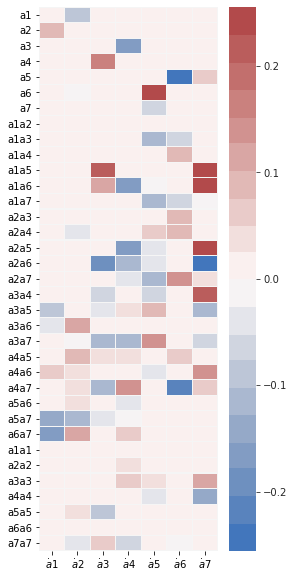

In [32]:
fig, ax = plt.subplots(1, 1, figsize=(4, 10))
plot_coefficients(model.coefficients(), input_features=pod_names, feature_names=feature_names, ax=ax);

In [33]:
print("Model score:", model.score(x, t=t))

Model score: 0.9648595433986561


In [34]:
x_dot = model.differentiate(x, t=t)
x_dot_train = model.predict(x_train)
x_dot_sim = model.predict(x_test)

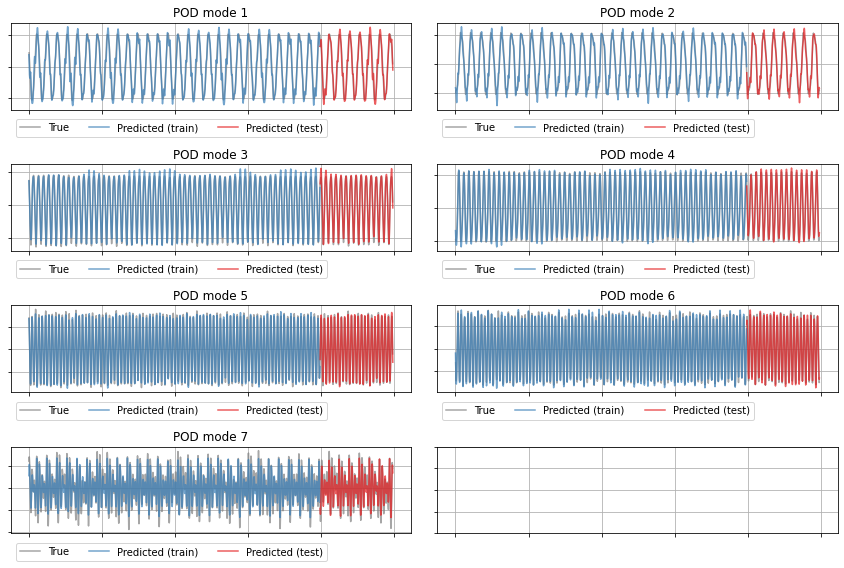

In [35]:
plot_trajectories(x_dot, x_dot_train, x_dot_sim, n_modes=r)

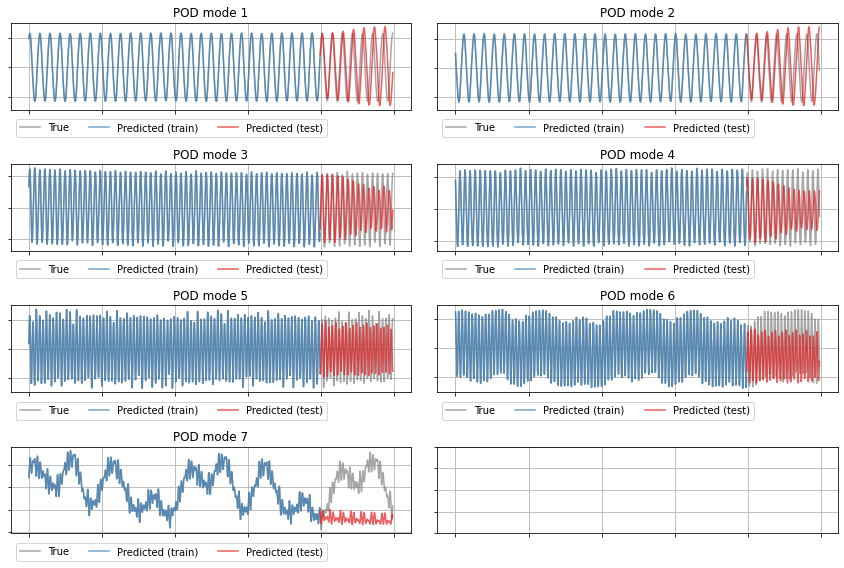

In [36]:
x_sim = model.simulate(x0_test, t_test)
plot_trajectories(x, x_train, x_sim, n_modes=r)

#### Mapping out the (r,$\lambda$) model landscape 

Generate a Pareto curve to map out the (r,$\lambda$) model space. This shows how the quality of the model-building changes as the number of modes (r) changes, and as the amount of sparsity varies ($\lambda$). In general, Pareto curves are made to identify the optimal tradeoff between the number of free parameters, and the prediction error. For us, both $r$ and $\lambda$ determine how many free parameters to use, since the largest set of free parameters here, the matrix of quadratic terms, scales like $O(r^3)$, and then $\lambda$ zeros out some subset of this matrix. 

Note that we are omitting the constraints and variable thresholds for simplicity here. There are three primary regions: unstable models, stable models, and "too sparse" (ineffective) models. It indicates that model instability is common, although these models may be useful for short times. There is considerable ongoing research in improving the robustness of these model discovery algorithms.

In [37]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    
    lambda_length = 50
    # Threshold values to map out
    pareto_thresholds = np.linspace(
        0.0, 5.0 * threshold, lambda_length
    )
    poly_order = 2
    threshold = 0.05
    tfrac = 0.8

    M = len(t)
    M_train = int(len(t) * tfrac)
    t_train = t[:M_train]
    t_test = t[M_train:]

    # Scanning models (coupled, quadratically nonlinear ODEs) with 3-14 modes 
    r_scan = range(3, 15)
    r_length = len(r_scan)
    rl_errs = np.zeros((r_length, lambda_length, 5))
    for r_current in r_scan:
        print("r = ", r_current)
        pod_names = ["a{}".format(i) for i in range(1, r_current + 1)]

        # Normalize the trajectories to the unit ball for simplicity
        normalization = sum(np.amax(abs(A), axis=0)[1 : r_current + 1])
        x = A[:, :r_current] / normalization

        # Build an initial guess
        initial_guess = np.zeros(
            (r_current, r_current + int(r_current * (r_current + 1) / 2))
        )
        initial_guess[0, 1] = 0.091
        initial_guess[1, 0] = -0.091

        # Split data into training and testing
        x_train = x[:M_train, :]
        x0_train = x[0, :]
        x_test = x[M_train:, :]
        x0_test = x[M_train, :]

        # Special library ordering needed again if constraints are used
        library_functions = [lambda x: x, lambda x, y: x * y, lambda x: x ** 2]
        library_function_names = [lambda x: x, lambda x, y: x + y, lambda x: x + x]
        sindy_library = ps.CustomLibrary(
            library_functions=library_functions, function_names=library_function_names
        )

        sindy_opt = ps.ConstrainedSR3(
            threshold=threshold, nu=1, initial_guess=initial_guess, max_iter=1000
        )

        rl_errs[r_current - r_scan[0], :, :] = pareto_curve(
            sindy_opt,
            sindy_library,
            ps.FiniteDifference,
            feature_names,
            discrete_time=False,
            thresholds=pareto_thresholds,
            x_fit=x_train,
            x_test=x_test,
            t_fit=t_train,
            t_test=t_test,
        )


r =  3
r =  4
r =  5
r =  6
r =  7
r =  8
r =  9
r =  10
r =  11
r =  12
r =  13
r =  14


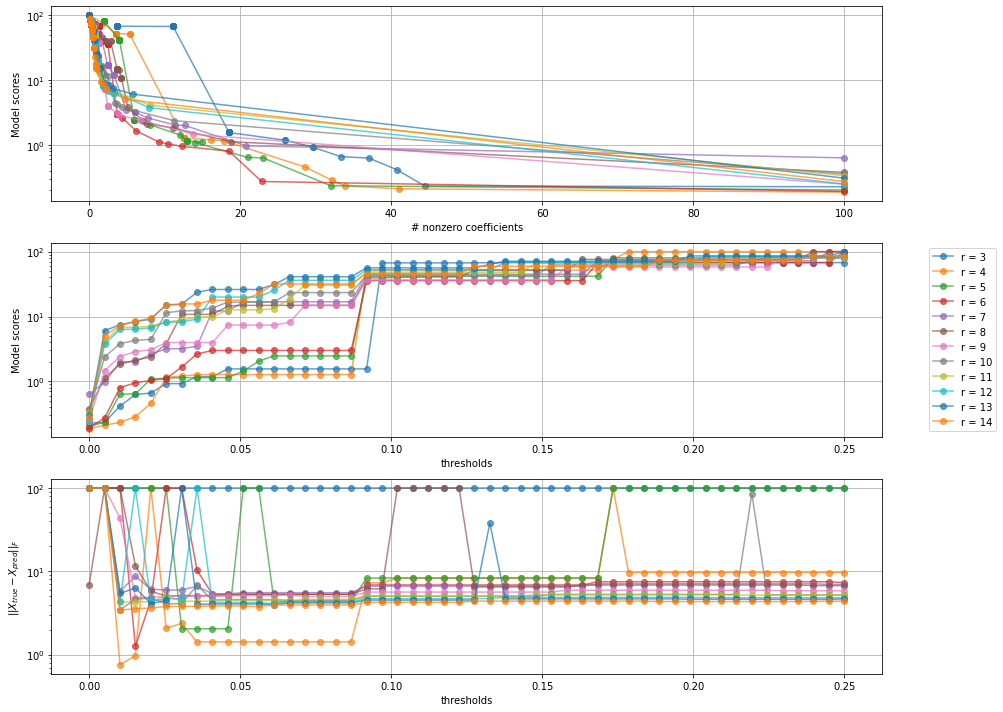

In [38]:
# Plot how the model scores, and Xdot frobenius error
# change as the threshold (or number of nonzero terms) is changed
from matplotlib.colors import LogNorm


fig, axs = plt.subplots(3, 1, figsize=(14, 10))
nonzeros = np.zeros((r_length, lambda_length))
scores = np.zeros((r_length, lambda_length))
xerr = np.zeros((r_length, lambda_length))
xdoterr = np.zeros((r_length, lambda_length))

alpha = 0.7

for i in r_scan:
    nonzero_coeffs = rl_errs[i - r_scan[0], :, 0]
    thresholds = rl_errs[i - r_scan[0], :, 1]
    model_scores = rl_errs[i - r_scan[0], :, 2]
    x_err = rl_errs[i - r_scan[0], :, 3]
    xdot_err = rl_errs[i - r_scan[0], :, 4]
    axs[0].semilogy(nonzero_coeffs, model_scores, marker="o", alpha=alpha)
    axs[0].set(xlabel="# nonzero coefficients", ylabel="Model scores")

    axs[1].semilogy(thresholds, model_scores, marker="o", alpha=alpha, label=f"r = {i}")
    axs[1].set(xlabel="thresholds", ylabel="Model scores")

    x_err[np.isnan(x_err)] = 1e2
    x_err[x_err > 1e2] = 1e2

    axs[2].semilogy(thresholds, x_err, marker="o", alpha=alpha)
    axs[2].set(xlabel="thresholds", ylabel=r"$||X_{true}-X_{pred}||_F$")

    nonzeros[i - r_scan[0], :] = nonzero_coeffs
    scores[i - r_scan[0], :] = model_scores
    xerr[i - r_scan[0], :] = x_err
    xdoterr[i - r_scan[0], :] = xdot_err


for ax in axs:
    ax.grid(True)

axs[1].legend(bbox_to_anchor=(1.05, 1), loc="upper left")
fig.tight_layout()
fig.show()

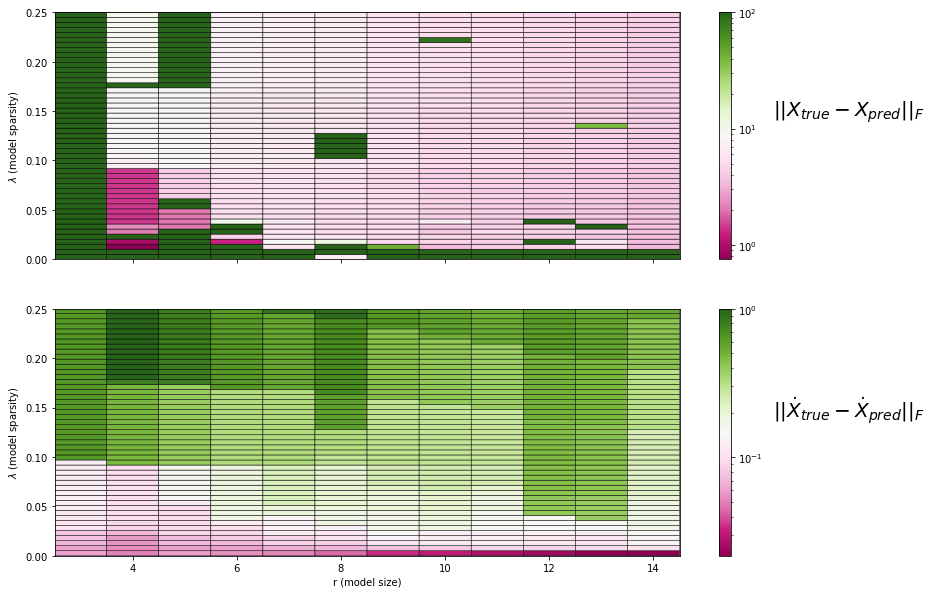

In [39]:
fig, axs = plt.subplots(2, 1, figsize=(14, 10))
X, Y = np.meshgrid(
    np.linspace(r_scan[0], r_scan[-1] + 1, r_scan[-1] - 1) - 0.5,
    thresholds,
    indexing="ij",
)

# truncate exploding errors at 1e2 for visualization's sake
xerr[np.isnan(xerr)] = 1e2
xerr[xerr > 1e2] = 1e2
xdoterr[np.isnan(xdoterr)] = 1e2
xdoterr[xdoterr > 1e2] = 1e2


c0 = axs[0].pcolor(
    X,
    Y,
    xerr,
    norm=LogNorm(vmin=abs(xerr).min(), vmax=abs(xerr).max()),
    cmap="PiYG",
    edgecolors="k",
    linewidths=0.5,
)
axs[0].set(ylabel=r"$\lambda$ (model sparsity)", xticklabels=[])
axs[0].text(1.15, 0.65, r'$||X_{true}-X_{pred}||_F$', transform=axs[0].transAxes, 
       fontsize=20, verticalalignment='top')
fig.colorbar(c0, ax=axs[0])

c1 = axs[1].pcolor(
    X,
    Y,
    xdoterr,
    norm=LogNorm(vmin=np.min(abs(xdoterr)), vmax=1e0),
    cmap="PiYG",
    edgecolors="k",
    linewidths=0.5,
)
axs[1].set(xlabel="r (model size)", ylabel=r"$\lambda$ (model sparsity)")
axs[1].text(1.15, 0.65, r'$||\dot{X}_{true}-\dot{X}_{pred}||_F$', transform=axs[1].transAxes, 
       fontsize=20, verticalalignment='top')
fig.colorbar(c1, ax=axs[1])

fig.show()